In [1]:
#conda create --solver=classic -n rapids-23.12 -c rapidsai -c conda-forge -c nvidia rapids=23.12 python=3.10 cuda-version=12.0
!pip install seaborn
!pip install tqdm

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import math
from sklearn import linear_model

from scipy.stats import linregress
from numba import cuda
import os
import warnings
warnings.simplefilter('ignore')

import os
import gc
import re
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
from tqdm.auto import tqdm
tqdm.pandas()

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import cudf
from cuml.linear_model import Ridge
from cuml.model_selection import train_test_split
from cuml.metrics import mean_squared_error
from cuml.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing,linear_model,compose,ensemble,model_selection
from cuml.preprocessing import LabelEncoder
import numpy as np


# Load the Keystroke Logging dataset
Let's have a look at all the data files

In [3]:
DATA_DIR = '/kaggle/input/linking-writing-processes-to-writing-quality/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


## Data dictionary

Let's dicover the data which are composed of :
- events
- activities
- scores

**Events**

| Column             | Definition                                                                |
| ------------------ | ------------------------------------------------------------------------- |
| essay_id_comp      | The unique ID of the essay                                                |
| event_id           | The index of the event, ordered chronologically                           |
| down_time          | The time of the down event in milliseconds                                |
| up_time            | The time of the up event in milliseconds                                  |
| action_time        | The duration of the event (the difference between down_time and up_time)  |
| activity           | The category of activity which the event belongs to                       |
| down_event         | The name of the event when the key/mouse is pressed                       |
| up_event           | The name of the event when the key/mouse is released                      |
| text_change        | The text that changed as a result of the event (if any)                   |
| cursor_position    | The character index of the text cursor after the event                    |
| word_count         | The word count of the essay after the event                               |

**Activities**

| Activity Name                  | Definition                                                                                 |
| ------------------------------ | ------------------------------------------------------------------------------------------ |
| Nonproduction                  | The event does not alter the text in any way                                               |
| Input                          | The event adds text to the essay                                                           |
| Remove/Cut                     | The event removes text from the essay                                                      |
| Paste                          | The event changes the text through a paste input                                           |
| Replace                        | The event replaces a section of text with another string                                   |
| Move From [x1, y1] To [x2, y2] | The event moves a section of text spanning character index x1, y1 to a new location x2, y2 |

**Scores**

| Column         | Definition                                                                        |
| -------------- | --------------------------------------------------------------------------------- |
| essay_id_comp  | The unique ID of the essay                                                        |
| score          | The score the essay received out of 6 (the prediction target for the competition) |
| split          | The train-test split of the essay                                                 |

# Explore the dataset

Let's look at the distribution of labels in the training set.

In [4]:
df_train_scores = pd.read_csv(DATA_DIR + "train_scores.csv")
df_train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


Text(0.5, 1.0, 'Distribution of scores')

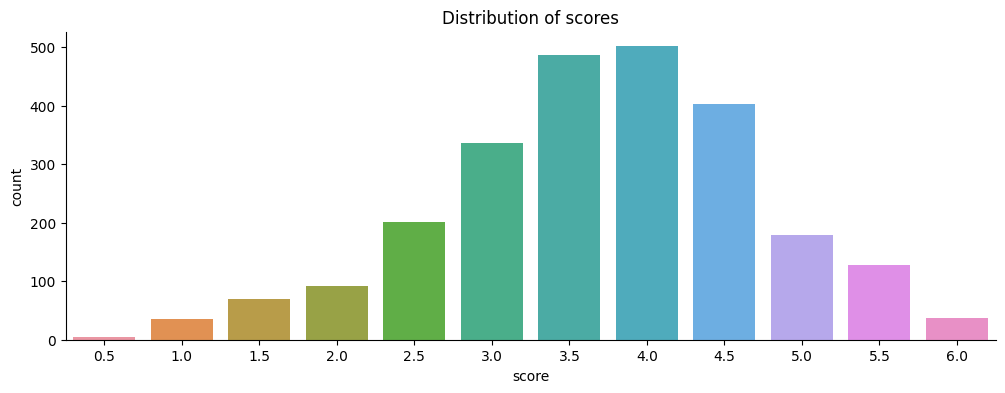

In [6]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_scores,
                   x="score")

ax.set_title("Distribution of scores")

# Event

In [5]:
df_train_logs = pd.read_csv(DATA_DIR + "train_logs.csv")
df_test_logs = pd.read_csv(DATA_DIR + "test_logs.csv")


print(df_train_logs.shape)
print(df_test_logs.shape)
df_train_logs.head()

(8405898, 11)
(6, 11)


,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


Now, let's discover the events distribution.

# Prepare data

Let's create the sentences for the transformer model.

First, pivot the table

Then, create a new column with the input text by concatening all event columns

Create the `vocab` list and use the `TextVectorization` layer to convert each event into integer.

# Create the model

In [6]:
#df_train_logs['time_ms'] = df_train_logs.groupby('id')['down_time'].transform(lambda x: x - x.shift(1))



#df_train_logs['time_ms']= df_train_logs['time_ms'].fillna(0)

First method for preprocessing

# secound method

In [12]:
activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
          'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']


def activity_counts(df):
    tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
    ret = list()
    for li in tqdm(tmp_df['activity'].values):
        items = list(Counter(li).items())
        di = dict()
        for k in activities:
            di[k] = 0
        for item in items:
            k, v = item[0], item[1]
            if k in di:
                di[k] = v
        ret.append(di)
    ret = pd.DataFrame(ret)
    cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
    ret.columns = cols
    return ret


def event_counts(df, colname):
    tmp_df = df.groupby('id').agg({colname: list}).reset_index()
    ret = list()
    for li in tqdm(tmp_df[colname].values):
        items = list(Counter(li).items())
        di = dict()
        for k in events:
            di[k] = 0
        for item in items:
            k, v = item[0], item[1]
            if k in di:
                di[k] = v
        ret.append(di)
    ret = pd.DataFrame(ret)
    cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
    ret.columns = cols
    return ret


def text_change_counts(df):
    tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
    ret = list()
    for li in tqdm(tmp_df['text_change'].values):
        items = list(Counter(li).items())
        di = dict()
        for k in text_changes:
            di[k] = 0
        for item in items:
            k, v = item[0], item[1]
            if k in di:
                di[k] = v
        ret.append(di)
    ret = pd.DataFrame(ret)
    cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
    ret.columns = cols
    return ret


punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
def match_punctuations(df):
    tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
    ret = list()
    for li in tqdm(tmp_df['down_event'].values):
        cnt = 0
        items = list(Counter(li).items())
        for item in items:
            k, v = item[0], item[1]
            if k in punctuations:
                cnt += v
        ret.append(cnt)
    ret = pd.DataFrame({'punct_cnt': ret})
    return ret


def get_input_words(df):
    tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
    tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
    tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
    tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
    tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
    tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
    tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
    tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
    tmp_df.drop(['text_change'], axis=1, inplace=True)
    return tmp_df

In [10]:
def make_feats(df):
    
    # id
    feats = pd.DataFrame({'id': df['id'].unique().tolist()})
    
    # time shift
    df['up_time_shift1'] = df.groupby('id')['up_time'].shift(1)
    df['action_time_gap'] = df['down_time'] - df['up_time_shift1']
    df.drop('up_time_shift1', axis=1, inplace=True)
    
    # cursor position shift
    df['cursor_position_shift1'] = df.groupby('id')['cursor_position'].shift(1)
    df['cursor_position_change'] = np.abs(df['cursor_position'] - df['cursor_position_shift1'])
    df.drop('cursor_position_shift1', axis=1, inplace=True)
    
    # word count shift
    df['word_count_shift1'] = df.groupby('id')['word_count'].shift(1)
    df['word_count_change'] = np.abs(df['word_count'] - df['word_count_shift1'])
    df.drop('word_count_shift1', axis=1, inplace=True)
    
    # stats feats
    for item in tqdm([
        ('event_id', ['max']),
        ('up_time', ['max']),
        ('action_time', ['sum', 'max', 'mean', 'std']),
        ('activity', ['nunique']),
        ('down_event', ['nunique']),
        ('up_event', ['nunique']),
        ('text_change', ['nunique']),
        ('cursor_position', ['nunique', 'max', 'mean']),
        ('word_count', ['nunique', 'max', 'mean']),
        ('action_time_gap', ['max', 'min', 'mean', 'std', 'sum']),
        ('cursor_position_change', ['max', 'mean', 'std', 'sum']),
        ('word_count_change', ['max', 'mean', 'std', 'sum'])
    ]):
        colname, methods = item[0], item[1]
        for method in methods:
            tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method}'})
            feats = feats.merge(tmp_df, on='id', how='left')
    
    # counts
    tmp_df = activity_counts(df)
    feats = pd.concat([feats, tmp_df], axis=1)
    tmp_df = event_counts(df, 'down_event')
    feats = pd.concat([feats, tmp_df], axis=1)
    tmp_df = event_counts(df, 'up_event')
    feats = pd.concat([feats, tmp_df], axis=1)
    tmp_df = text_change_counts(df)
    feats = pd.concat([feats, tmp_df], axis=1)
    tmp_df = match_punctuations(df)
    feats = pd.concat([feats, tmp_df], axis=1)
    
    # input words
    tmp_df = get_input_words(df)
    feats = pd.merge(feats, tmp_df, on='id', how='left')
    
    # compare feats
    feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
    feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
    feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
    feats['idle_time_ratio'] = feats['action_time_gap_sum'] / feats['up_time_max']
    
    return feats

In [37]:
train_fts = make_feats(df_train_logs)
test_fts = make_feats(df_test_logs)


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [43]:


# X = df_train_COMBINED.reindex(np.random.permutation(df_train_COMBINED.index))

#def shuffle(matrix, target, test_proportion):
#    ratio = int(len(matrix) / test_proportion)
#    X_train = matrix.iloc[ratio:]
#    X_test = matrix.iloc[:ratio]
  #  Y_train = target.iloc[ratio:]
  #  Y_test = target.iloc[:ratio]
#   return X_train, X_test, Y_train, Y_test

# Assuming df_train_logs and df_train_scores are pandas DataFrames
#X_train, X_test, Y_train, Y_test = shuffle(train_feats.loc[:, train_feats.columns != 'score'], train_feats['score'], 3)

In [52]:
train_feats=train_fts
test_feats=test_fts

train_feats = train_feats.merge(df_train_scores, on='id', how='left')

train_feats=cudf.DataFrame.from_pandas(train_feats)


train_index=train_feats['id']

train_feats=train_feats.drop('id', axis=1)


X_train=train_feats.loc[:, train_feats.columns != 'score']

X_train

# Assuming X_train and Y_train are cuDF DataFrames
# Convert your DataFrame to cuDF DataFrame if it's not already
#X_train = cudf.DataFrame.from_pandas(X_train)
#Y_train = cudf.Series(Y_train)

X_train=train_feats.loc[:, train_feats.columns != 'score']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_cols = X_train.select_dtypes(include=numerics).columns
cat_cols = ['id']
# Handle categorical columns - Example with One-Hot Encoding
# This is a basic example. You might need a more complex approach based on your data

# Assuming X_train and X_test are cuDF DataFrames
#for col in cat_cols:
#    le = LabelEncoder()
    
    # Temporarily append 'unseen_category' to the column for fitting
#    temp_col = X_train[col].astype('str').append(cudf.Series(['unseen_category']))
#    le.fit(temp_col)

    # Now transform the original data without the appended category
#    X_train[col] = le.transform(X_train[col].astype('str'))

le = LabelEncoder()
train_feats['score']=le.fit_transform(train_feats['score'])

# Standardize numerical columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# List of alphas to try
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 10, 15, 20, 100, 1000]

# Initialize variables to store the best alpha and its corresponding error
best_alpha = None
best_error = float('inf')

X_train=X_train.fillna(0)

# Iterate over alphas
for alpha in alphas:
    # Create Ridge model with current alpha
    model = Ridge(alpha=alpha)

    # Split data into training and validation sets
    X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(X_train, train_feats['score'], test_size=0.2)

    # Fit the model
    model.fit(X_train_split, Y_train_split)

    # Make predictions on the validation set
    predictions = model.predict(X_val_split).round()

    # Calculate mean squared error
    mse = mean_squared_error(Y_val_split.astype('int32'), predictions.astype('int32'))

    # Update best alpha if this model is better
    if mse < best_error:
        best_error = mse
        best_alpha = alpha

print(f"Best alpha: {best_alpha} with MSE: {best_error}")

# You can now train a final model using the best alpha
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, train_feats['score'])

# Predictions and further evaluations can be done using final_model



Best alpha: 1 with MSE: 1.8562753036437247


Ridge()

In [28]:
X_test_data.head(5)

,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,action_time_gap_max,action_time_gap_min,action_time_gap_mean,action_time_gap_std,action_time_gap_sum,cursor_position_change_max,cursor_position_change_mean,cursor_position_change_std,cursor_position_change_sum,word_count_change_max,word_count_change_mean,word_count_change_std,word_count_change_sum,activity_0_count,activity_1_count,activity_2_count,activity_3_count,activity_4_count,down_event_0_count,down_event_1_count,down_event_2_count,down_event_3_count,down_event_4_count,down_event_5_count,down_event_6_count,down_event_7_count,down_event_8_count,down_event_9_count,down_event_10_count,down_event_11_count,down_event_12_count,down_event_13_count,down_event_14_count,down_event_15_count,up_event_0_count,up_event_1_count,up_event_2_count,up_event_3_count,up_event_4_count,up_event_5_count,up_event_6_count,up_event_7_count,up_event_8_count,up_event_9_count,up_event_10_count,up_event_11_count,up_event_12_count,up_event_13_count,up_event_14_count,up_event_15_count,text_change_0_count,text_change_1_count,text_change_2_count,text_change_3_count,text_change_4_count,text_change_5_count,text_change_6_count,text_change_7_count,text_change_8_count,text_change_9_count,text_change_10_count,text_change_11_count,text_change_12_count,text_change_13_count,text_change_14_count,punct_cnt,input_word_count,input_word_length_mean,input_word_length_max,input_word_length_std,word_time_ratio,word_event_ratio,event_time_ratio,idle_time_ratio
0,-2.153788,-3.657530,-2.117589,-0.221853,-0.578699,-0.384579,-3.876141,-3.622634,-3.534902,-1.940123,-2.320836,-2.301829,-2.315108,-2.259030,-2.261718,-2.290703,1.281650,54.476711,1383.134398,NaN,-3.584342,-1.383831,-0.626371,NaN,-0.790841,-0.320502,-4.869358,NaN,-1.963049,-2.274225,-1.179597,-0.565806,-0.49608,-0.201513,-2.242766,-2.023326,-1.161499,-0.504728,-0.204789,-0.815211,-0.254728,-2.207639,-1.240264,-0.130185,-0.120506,-0.521468,-0.284174,-0.843806,-0.183039,-0.030123,-2.242872,-2.023326,-1.161499,-0.504728,-0.204789,-0.815211,-0.254728,-2.207639,-1.240264,-0.130185,-0.120506,-0.521468,-0.284174,-0.843806,-0.183039,-0.030123,-2.153790,-1.937993,-0.565806,-2.01149,-1.225554,-0.357388,-0.818846,-0.508262,-0.464901,-0.55654,-0.29763,-0.307005,-0.352527,-0.222826,-0.308779,-1.713055,-2.001624,-5.808462,-0.355245,-0.581832,-2.185803,-4.55524,-2.175080,-2.480104
1,-2.153788,-3.831957,-2.117964,-0.223381,-1.802370,-0.325385,-3.876141,-3.622634,-3.534902,-1.940123,-2.320836,-2.301829,-2.315108,-2.259030,-2.255918,-2.279174,-3.121187,-54.327946,-1386.404006,NaN,-6.693518,-1.383831,-0.626371,NaN,-0.790841,-0.320502,-4.869358,NaN,-1.963049,-2.274225,-1.179597,-0.565806,-0.49608,-0.201513,-2.240700,-2.031643,-1.161499,-0.504728,-0.204789,-0.815211,-0.254728,-2.207639,-1.240264,-0.130185,-0.120506,-0.521468,-0.284174,-0.843806,-0.183039,-0.030123,-2.240805,-2.031643,-1.161499,-0.504728,-0.204789,-0.815211,-0.254728,-2.207639,-1.240264,-0.130185,-0.120506,-0.521468,-0.284174,-0.843806,-0.183039,-0.030123,-2.152053,-1.944974,-0.565806,-2.01149,-1.225554,-0.357388,-0.818846,-0.508262,-0.464901,-0.55654,-0.29763,-0.307005,-0.352527,-0.222826,-0.308779,-1.713055,-1.997795,-3.460805,-0.333907,-0.581832,-2.172115,14.48499,-2.174880,-14.741971
2,-2.153788,-4.108731,-2.117729,-0.221317,-1.034983,-0.272422,-3.876141,-3.355041,-3.277422,-1.772317,-2.320836,-2.301829,-2.315108,-2.253226,-2.255918,-2.284939,-3.273283,-58.086595,-1482.077512,NaN,-6.800924,-1.383831,-0.626371,NaN,-0.790841,-0.291568,24.512727,NaN,-1.959550,-2.274225,-1.179597,-0.565806,-0.49608,-0.201513,-2.241733,-2.027484,-1.161499,-0.504728,-0.204789,-0.815211,-0.254728,-2.207639,-1.240264,-0.130185,-0.120506,-0.521468,-0.284174,-0.843806,-0.183039,-0.030123,-2.241839,-2.027484,-1.161499,-0.

In [22]:


test_index=test_feats['id']

test_feats=test_feats.drop('id', axis=1)


In [29]:
X_test_data=test_feats


X_test_data[num_cols] = scaler.transform(X_test_data[num_cols].fillna(0))

# Generate the submission file

Let's prepare the test data and do the predictions

In [64]:
predictions_le=final_model.predict(X_test_data).round().astype('int32')

In [83]:
predictions=le.inverse_transform(predictions_le)

test_index
test_index_pd = test_index.to_frame()
predictions_pd=predictions.to_pandas()
predictions_df = predictions_pd.to_frame(name='score')

test_index_pd = test_index_pd.reset_index(drop=True)
predictions_pd = predictions_pd.reset_index(drop=True)


submission= pd.concat([test_index_pd,predictions_df],axis= 1)

In [84]:
submission.to_csv("submission.csv", index=False)